In [1]:
#load data

import pandas as pd
from loaddata import defineTestSet,defineResponse,defineFeatures,defineTrainingSets,defineSplits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
import pickle
import seaborn as sns
from datetime import datetime
import os
from config import ensemble_dir, rand_var,z_score_ensemble_dir
from tools.make_model import optimise_logres_featsel,optimise_rf_featsel,optimise_svc_featsel
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RandomizedSearchCV

In [2]:
#traing data

her2=0
rcut = 1

df_train = pd.read_csv('inputs/training_df.csv')

feats_chemo = defineFeatures('chemo', her2=her2)
chemo_Xtrain, chemo_ytrainCateg, chemo_ytrainScore, chemo_ytrainID = defineTrainingSets(df_train, feats_chemo, her2=her2)
chemo_splits = defineSplits(chemo_Xtrain, chemo_ytrainCateg)

feats_clinical = defineFeatures('clinical', her2=her2)
clinical_Xtrain, clinical_ytrainCateg, clinical_ytrainScore, clinical_ytrainID = defineTrainingSets(df_train, feats_clinical, her2=her2)
clinical_splits = defineSplits(clinical_Xtrain, clinical_ytrainCateg)



ytrain_pCR = defineResponse(df_train, 'pCR', her2=her2)

In [4]:
#load test data

df_test_pCR_pos = pd.read_csv('inputs//testing_her2pos_df.csv')
df_test_pCR_neg = pd.read_csv('inputs//testing_her2neg_df.csv')




chemo_x_test_pCR_pos = defineTestSet(df_test_pCR_pos,feats_chemo,her2=her2)
chemo_x_test_pCR_neg = defineTestSet(df_test_pCR_neg,feats_chemo,her2=her2)
chemo_x_test_comb = pd.concat([chemo_x_test_pCR_pos,chemo_x_test_pCR_neg])

clinical_x_test_pCR_pos = defineTestSet(df_test_pCR_pos,feats_clinical,her2=her2)
clinical_x_test_pCR_neg = defineTestSet(df_test_pCR_neg,feats_clinical,her2=her2)
clinical_x_test_comb = pd.concat([clinical_x_test_pCR_pos,clinical_x_test_pCR_neg])




y_test_pCR_pos = defineResponse(df_test_pCR_pos, 'pCR', her2=her2)
y_test_pCR_neg = defineResponse(df_test_pCR_neg, 'pCR', her2=her2)

y_test_comb = pd.concat([y_test_pCR_pos,y_test_pCR_neg])

## Fig 4b z score calculations

In [5]:


base_logres_model = optimise_logres_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_
base_rf_model = optimise_rf_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_
base_svc_model = optimise_svc_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_




used_model_list = [
    ('Logistic Regression',base_logres_model),
    ('Random Forest Classifier',base_rf_model),
    ('Support Vector Classifier',base_svc_model)

    
    
]



In [6]:
min_weight =0
max_weight = 5

weights_of_models = range(min_weight,max_weight,1)

possible_combinations = [
    [w1,w2,w3]
    for w1 in weights_of_models
    for w2 in weights_of_models
    for w3 in weights_of_models

]

filtered_combinations = [i for i in possible_combinations if any(i)]#remove all 0 combination which will break voting classifier


param_grid = {
 'weights':filtered_combinations   
}

base_ensemble_model_weighted = VotingClassifier(estimators=used_model_list, voting='soft')

base_ensemble_search = RandomizedSearchCV(base_ensemble_model_weighted, param_grid, cv=chemo_splits,scoring='roc_auc',return_train_score=True, n_jobs=-1, verbose=0,n_iter=1500,random_state=rand_var)

base_ensemble_search.fit(chemo_Xtrain,ytrain_pCR)




Fitting 5 folds for each of 124 candidates, totalling 620 fits


c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 124 is smaller than n_iter=1500. Running 124 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,
        14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  31,  32,  33,  38,  39,  41,  44,  45,  46,  48,  49,
        50,  51,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  66,
        67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  80,  81,
        82,  83,  84,  85,  86,  87,  90,  91,  92,  95,  96,  97,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 115, 117, 118, 121, 123, 124, 125, 126, 127, 128...
                   n_iter=1500, n_jobs=-1,
                   param_distributions={'weights': [[0, 0, 1], [0, 0, 2],
                                                    [0, 0, 3], [0, 0, 4],
                                                    [0, 1, 0], [0, 1, 1],
                                                    [0, 1, 2], [0, 1, 3],
                                                    [0, 1, 4], [0, 2, 0],
                                                    [0, 2, 1], [0, 2, 2],
                                                    [0, 2, 3], [0, 2, 4],
                                                    [0, 3, 0], [0, 3, 1],
                                                    [0, 3, 2], [0, 3, 3],
                                                    [0, 3, 4], [0, 4, 0],
                                                    [0, 4, 1], [0, 4, 2],
                                                    [0, 4, 3], [0, 4, 4],
                                                    [1, 0, 0], [1, 0, 1],
                                                    [1, 0, 2], [1, 0, 3],
                                                    [1, 0, 4], [1, 1, 0], ...]},
                   random_state=123, return_train_score=True, scoring='roc_auc',
                   verbose=1)

In [8]:

best_base_ensemble_model = base_ensemble_search.best_estimator_

y_pred_prob_base = best_base_ensemble_model.predict_proba(chemo_x_test_comb)[:, 1]

base_auc = roc_auc_score(y_test_comb, y_pred_prob_base)



In [9]:
#dataframe to save the z scores

feature_importance = pd.DataFrame(index=chemo_x_test_pCR_pos.columns, columns=['z-score'])

In [11]:

for feature in chemo_x_test_pCR_pos.columns:
    x_without_feat = chemo_Xtrain.drop(columns=[feature])
    
    without_feat_logres_model = optimise_logres_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_
    without_feat_rf_model = optimise_rf_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_
    without_feat_svc_model = optimise_svc_featsel(chemo_Xtrain,ytrain_pCR,cut=float(rcut),cv=chemo_splits,max = 2000).best_estimator_




    without_feat_used_model_list = [
        ('Logistic Regression',without_feat_logres_model),
        ('Random Forest Classifier',without_feat_rf_model),
        ('Support Vector Classifier',without_feat_svc_model)

        
        
    ]
    
    
    without_ensemble_model_weighted = VotingClassifier(estimators=without_feat_used_model_list, voting='soft')

    without_ensemble_search = RandomizedSearchCV(base_ensemble_model_weighted, param_grid, cv=chemo_splits,scoring='roc_auc',return_train_score=True, n_jobs=-1, verbose=0,n_iter=1500,random_state=rand_var)

    without_ensemble_search.fit(x_without_feat,ytrain_pCR)
    
    without_ensemble_best_model = without_ensemble_search.best_estimator_
    
    test_x_without_feat = chemo_x_test_comb.drop(columns=[feature])
    

    y_without_feat_pred_prob = without_ensemble_best_model.predict_proba(test_x_without_feat)[:, 1]
    
    auc_without_feat = roc_auc_score(y_test_comb, y_without_feat_pred_prob)
    
    z_score = (auc_without_feat - base_auc) / np.std(y_pred_prob_base)
    
    feature_importance.loc[feature, 'z-score'] = z_score

c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 124 is smaller than n_iter=1500. Running 124 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 124 is smaller than n_iter=1500. Running 124 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 124 is smaller than n_iter=1500. Running 124 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\luejay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 124 is smaller than n

In [12]:
feature_importance['z-score'] = pd.to_numeric(feature_importance['z-score'], errors='coerce')

In [13]:
os.makedirs(z_score_ensemble_dir, exist_ok=True)

tm = datetime.now()
modelname = 'LRRFSVC'
filename = "EnsembleZscore_model_{}_random_{}_Date_{}_{}_{}_{}.p".format(modelname,rand_var,tm.year,tm.month,tm.day,tm.strftime("%H_%M_%S"))


with open(z_score_ensemble_dir+filename,'wb') as w:
    pickle.dump(feature_importance,w)

## Fig 4b graphing

In [16]:
with open(z_score_ensemble_dir+"EnsembleZscore_model_LRRFSVC_random_123_Date_2023_7_27_06_04_54.p",'rb') as w:
       
    feature_df = pickle.load(w, encoding='utf-8')

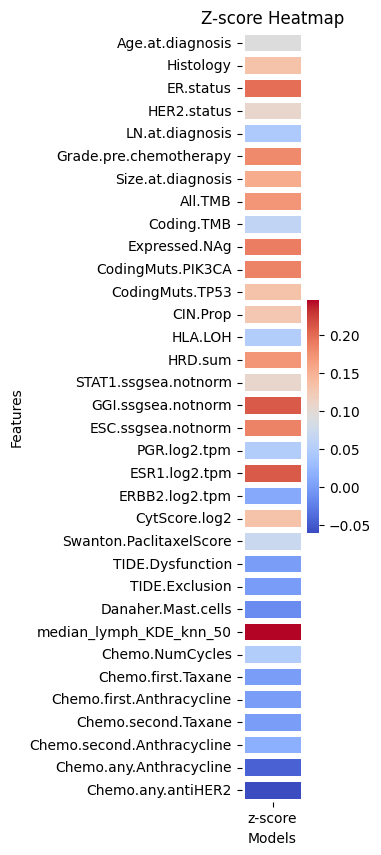

In [19]:
fig, ax = plt.subplots(figsize=(1, 10))

sns.heatmap(feature_df, cmap='coolwarm', annot=False, fmt=".3f", ax=ax,linewidths=3)


ax.set_xlabel("Models")
ax.set_ylabel("Features")
ax.set_title("Z-score Heatmap")

plt.savefig('images/EDfig9b', bbox_inches='tight', transparent=False, dpi=300)

plt.show()

## Figure 4c

In [4]:
#ensemble models to use

with open(ensemble_dir+"Modelnum_3_random_123_Feats_clinical_Date_2023_7_26_15_39_12.p",'rb') as w:
       
    clinical_ensemble = pickle.load(w, encoding='utf-8')
    
    
with open(ensemble_dir+"Modelnum_3_random_123_Feats_chemo_Date_2023_7_26_15_34_25.p",'rb') as w:
       
    chemo_ensemble = pickle.load(w, encoding='utf-8')



In [7]:
clinical_y_pred = clinical_ensemble.predict(clinical_x_test_comb)
chemo_y_pred = chemo_ensemble.predict(chemo_x_test_comb)

  

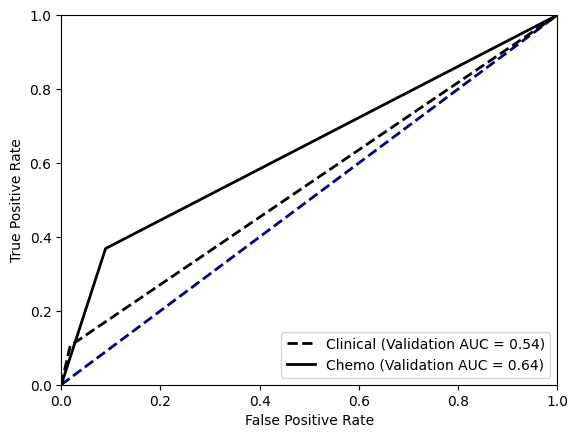

In [9]:



plt.figure()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    

    

fp_rate, tp_rate, thresholds = roc_curve(y_test_comb, clinical_y_pred)
        
roc_auc = auc(fp_rate, tp_rate)
   
plt.plot(fp_rate, tp_rate, color='black', lw=2, linestyle='--',label='Clinical (Validation AUC = %0.2f)' % roc_auc)
    
    
    
    
fp_rate, tp_rate, thresholds = roc_curve(y_test_comb, chemo_y_pred)
        
roc_auc = auc(fp_rate, tp_rate)
   
plt.plot(fp_rate, tp_rate, color='black', lw=2, label='Chemo (Validation AUC = %0.2f)' % roc_auc)
    

    
    
plt.legend(loc='lower right')
    
plt.show()
